# MoE Scaling Laws: Experimental Validation

This notebook implements, demonstrates, and validates the theoretical scaling laws presented in: [_"Novel Scaling Laws for MoE Architectures: A Theoretical Analysis"_](https://github.com/wrmedford/moe-scaling) by Wes Medford, et al. This notebook aims to show how an on-bus vRAM available PCIe 4.0 card, like the NVIDIA H100, scales with the number and sizes of experts in a mixture of experts model compared to a unified memory, CPU/GPU high bandwidth, cache available system like the NVIDIA GH200. 

## Assumptions:

This experiment makes a few assumptions in order to simulate scaling based on real-world hardware. For example:

* Cache size (bytes): the size of the available cache or vRAM. Used to simulate modern L3, L2 caches and fast GPU vRAM in a typical MoE situation where "experts" are typically expected to be loaded into fast retreivable memory.
* Bus bandwidth (bytes/second): the amount/speed of data that can be transmitted directly on bus via GPU or cache. For example, on am modern, PCIe 4.0 x16 link, this may be many GB/s.
* Cache bandwidth (bytes/second): the amount/speed of on bus cache bandwidth constraints. For example, for in-memory caches on GDDR6/X, this may be ~4GB/s.
* Cache hit latency (seconds): how quickly the fast cache / vRAM can be hit successfully.
* Cache miss_latency (seconds): how quickly the cache is missed and resolved to slower in-memory or on-disk objects.

In [1]:
# Import local script in scaling.py
from scaling import *

# Import notebook dependencies
import numpy as np
import matplotlib.pyplot as plt

# Bootstraps a visualizer ready to display charts
visualizer = Visualizer()

# PCIe GPU based system

This deomstrates a typical AI/ML system with parameters targeting GPU workloads. It's assumed that ONLY GPU vRAM and compute are available and no unified memory or on-board caches are available.

In [2]:
# system config for GPU based system:
# adjust to show different scaling distributions.
#
# The following assumes a single H100 NVL on a system
# with no unified memory: i.e., only vram on the GPU is used.
#
# Reference arch: https://resources.nvidia.com/en-us-tensor-core/nvidia-tensor-core-gpu-datasheet
system_config = GPUSystemConfig(
    # 94GB GPU memory
    gpu_mem_size=94 * 1024**3,
    # 128 GB/s
    gpu_bus_bw=128 * 1024**3,
    # 3.9 TB/s
    gpu_bandwidth=3.9 * 1024**4,
    # 100ns
    gpu_hit_latency=1e-7,
    # 10μs
    gpu_miss_latency=1e-5,
)

simulator = ScalingLawSimulator(system_config)
runner = ExperimentRunner(simulator)

## Experiment 1: Expert Count Scaling

This experiment shows the relationship between expert count and cache efficiency.

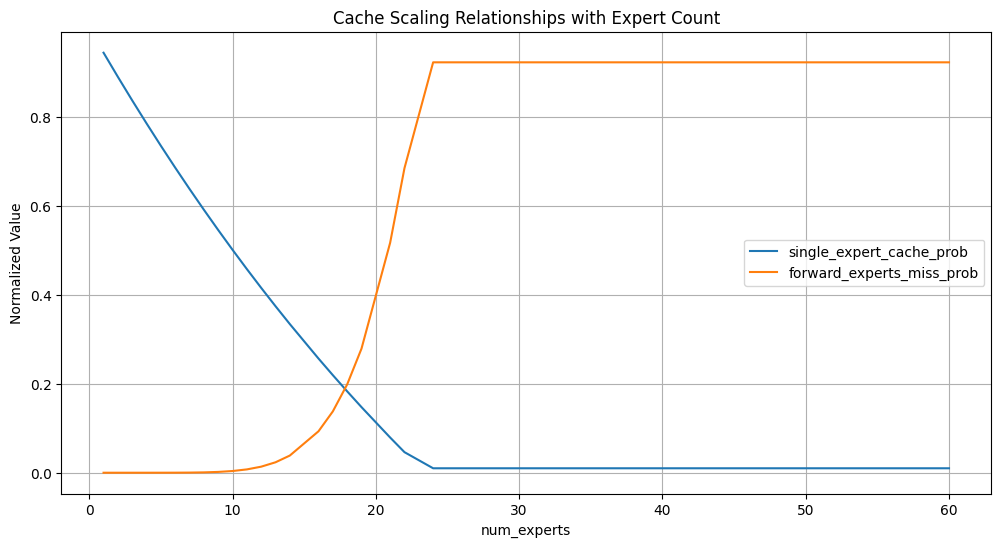

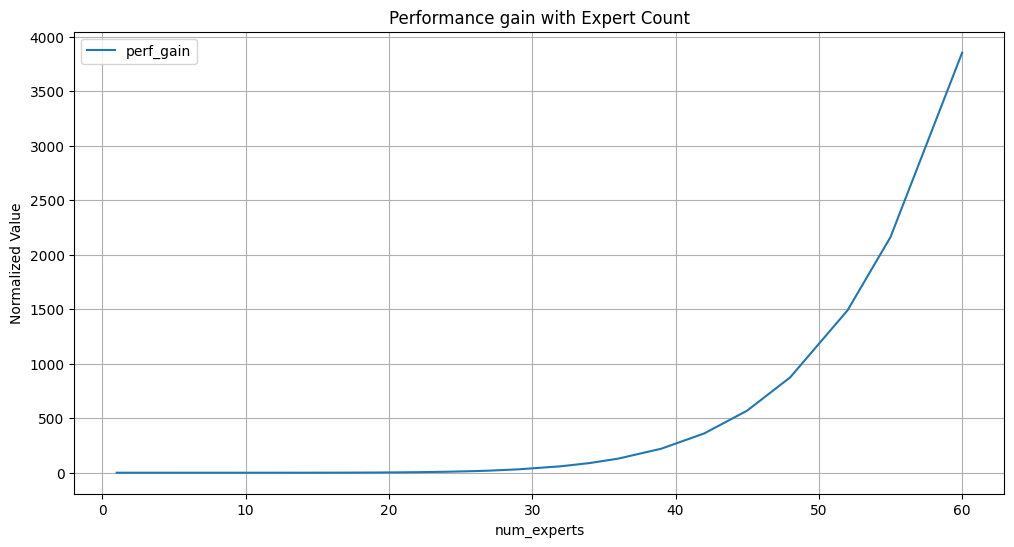

In [3]:
results_count = runner.expert_count_sweep(
    start_experts=1,
    end_experts=60,
    step=60,
    expert_size=2 * 1024**3,  # 2GB per expert
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_count,
    "num_experts",
    ["single_expert_cache_prob", "forward_experts_miss_prob"],
    "Cache Scaling Relationships with Expert Count",
)

visualizer.plot_scaling_relationships(
    results_count,
    "num_experts",
    ["perf_gain"],
    "Performance gain with Expert Count",
)

As the theoretical performance gains increase with the number of experts increasing, there exists a sweet spot where the cache "miss" probability crosses over with the miss caching probability. This demonstrates the proposed relationship between expert count, expert size, and the cache effeciency rate.

However, with only a few experts at 2GB / expert, the cache miss probability quickly rises making performance gains on a typical H100 negligable.

## Experiment 2: Expert Size Scaling

This experiment examines how expert size affects system performance

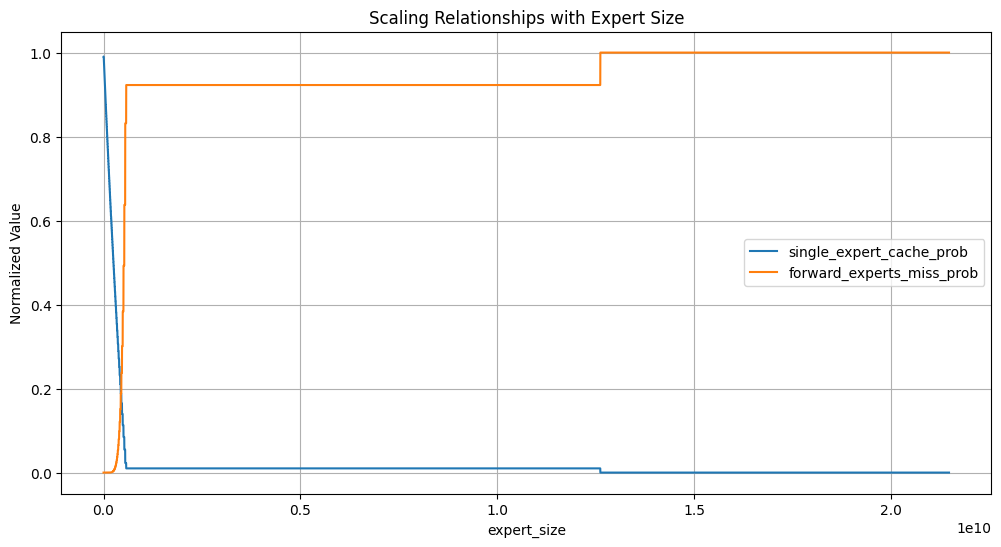

In [4]:
results_size = runner.expert_size_sweep(
    # !!!!! NOTE: only using 100 experts.
    num_experts=100,
    start_size=1024 * 128,  # 128kb
    end_size=20 * 1024**3,  # 20GB
    step=1024 * 16,  # 16KB steps
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_size,
    "expert_size",
    ["single_expert_cache_prob", "forward_experts_miss_prob"],
    "Scaling Relationships with Expert Size",
)

As expert size increases, note the theoretical and dramatic decrease in performance gains. As expert sizes increase, caching capabilities drop. This shows the typical industry standard to put more v-linked GPUs on cluster to enable more parameters and, in a mixture of experts scenerio, load all experts necessary for training or inference.

## Experiment 3: Performance Contour Analysis

This experiment aims to show the relationship between expert count,
size, and performance gain across all 3 dimensions.

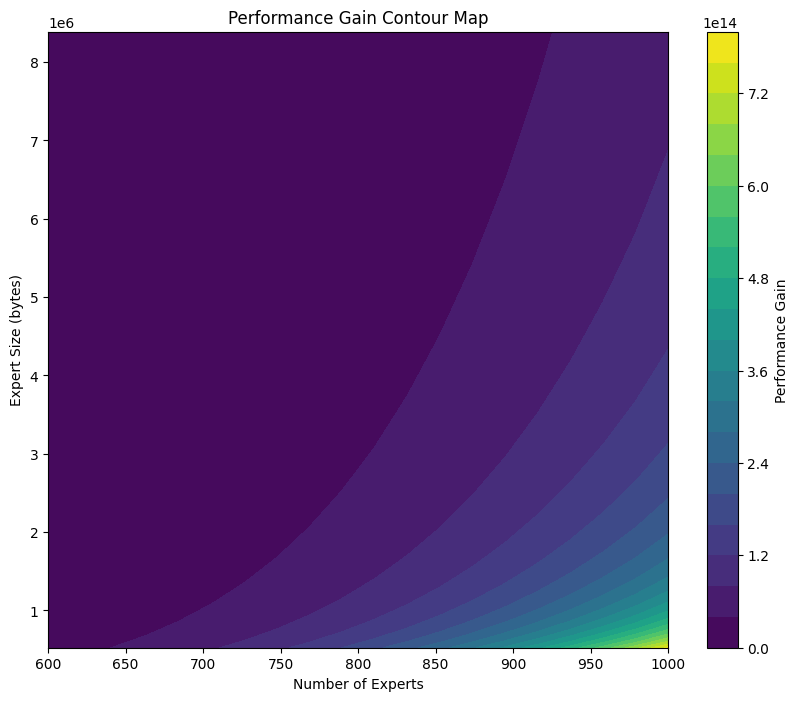

In [5]:
# Parameter ranges for number of experts:
# from 100 to 1500 experts in steps of 20.
num_experts_range = np.linspace(600, 1000, 20)

# Parameter range for the size of experts:
# start with 512KB and go up to 8MB.
# Use 512KB steps.
expert_sizes_range = np.linspace(1024 * 512, 1024 * 1024 * 8, 1024 * 512)

# Calculate performance matrix
perf_matrix = np.zeros((len(expert_sizes_range), len(num_experts_range)))
for i, size in enumerate(expert_sizes_range):
    for j, num_experts in enumerate(num_experts_range):
        config = MoEConfig(int(num_experts), int(size), 8)
        perf_matrix[i, j] = simulator.calculate_performance_gain(config)

# Plot contour graph
visualizer.plot_performance_contour(
    num_experts_range, expert_sizes_range, perf_matrix, "Performance Gain Contour Map"
)

Note that beginning around 1000 extremely small experts, caching performance gains are realized. Performance gains continue for small expert sizes given the proposed scaling law but, as experts grow, real performance gains on a typical H100 are non-existent unless extremely small experts (of size <512KB) are used.

# Unified memory system

The following system uses a unified memory schematic where on-board CPU/GPU have a fast link and high bandwidth demonstrating the MoE scaling law using fast caches and small experts:

In [36]:
# The default "UnifiedMemSystemConfig" uses a GH200 with the following params:
#
# * 144 ARM Neoverse v2 cores
# * 1MB L2 cache per core
# * 900GB/s NVLink
# * 9.8TB/s HBM3
#
# Reference: https://resources.nvidia.com/en-us-grace-cpu/grace-hopper-superchip
gh200_system = UnifiedMemSystemConfig()

gh200_simulator = ScalingLawSimulator(gh200_system)
gh200_runner = ExperimentRunner(gh200_simulator)

# Experiment 1: Expert count scaling

Demonstrating upwards of 10,000 experts of 2GB, this experiment demonstrates the high scalability of the MoE scaling law with fast on-board caches.

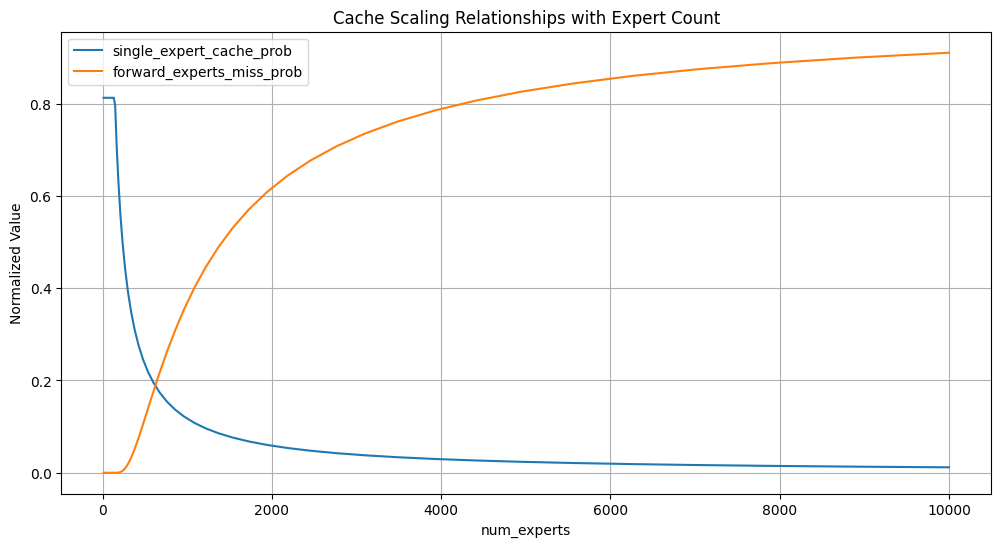

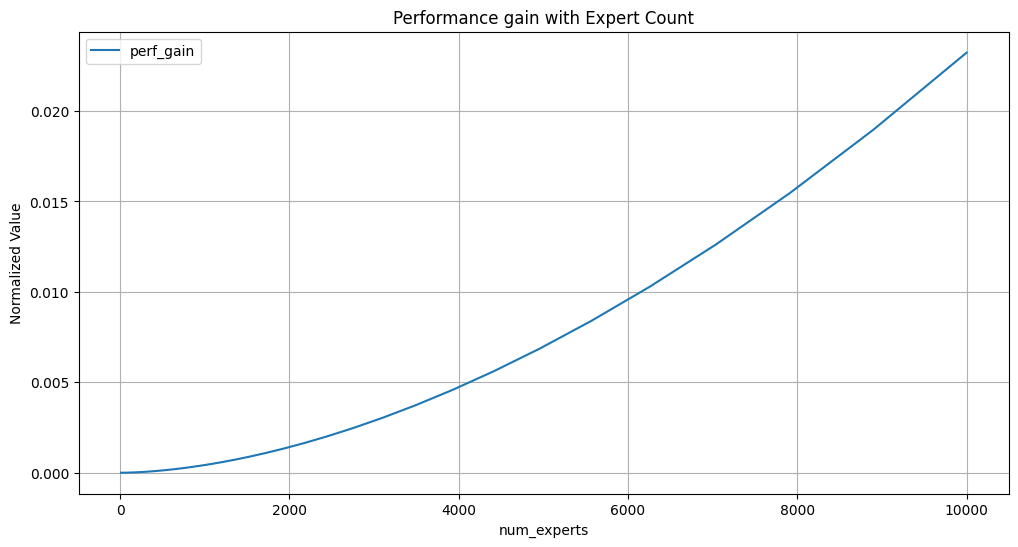

In [37]:
results_count = gh200_runner.expert_count_sweep(
    start_experts=10,
    end_experts=10000,  # !!!! Note: large number of experts, demonstrates high scaling
    step=60,
    expert_size=2 * 1024**3,  # 2GB per expert
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_count,
    "num_experts",
    ["single_expert_cache_prob", "forward_experts_miss_prob"],
    "Cache Scaling Relationships with Expert Count",
)

visualizer.plot_scaling_relationships(
    results_count,
    "num_experts",
    ["perf_gain"],
    "Performance gain with Expert Count",
)

As experts scale up, the caching capabilities remain high and the miss probability lograithmically scales with the number of experts.

## Experiment 2: Expert size scaling

This experiment shows the unified memory capabilities as expert size increases.

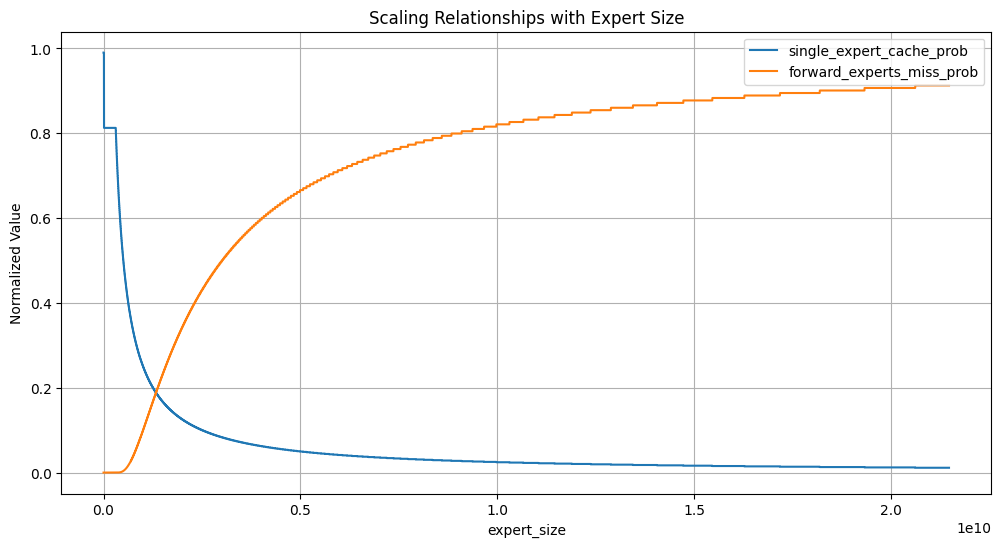

In [38]:
results_size = gh200_runner.expert_size_sweep(
    num_experts=1000,  # !!! Note: 1000 experts
    start_size=1024 * 128,  # 128kb
    end_size=20 * 1024**3,  # 20GB
    step=1024 * 16,  # 16KB steps
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_size,
    "expert_size",
    ["single_expert_cache_prob", "forward_experts_miss_prob"],
    "Scaling Relationships with Expert Size",
)

As the size of experts scale on with a unified memory system, the caching capabilities remain.

Note that this is a similar structure to how the scaling relationship works with number of experts increasing.

## Experiment 3: Performance Contour Analysis

This experiment aims to show the relationship between expert count,
size, and performance gain across all 3 dimensions on a unified memory system with fast caching capabilities.

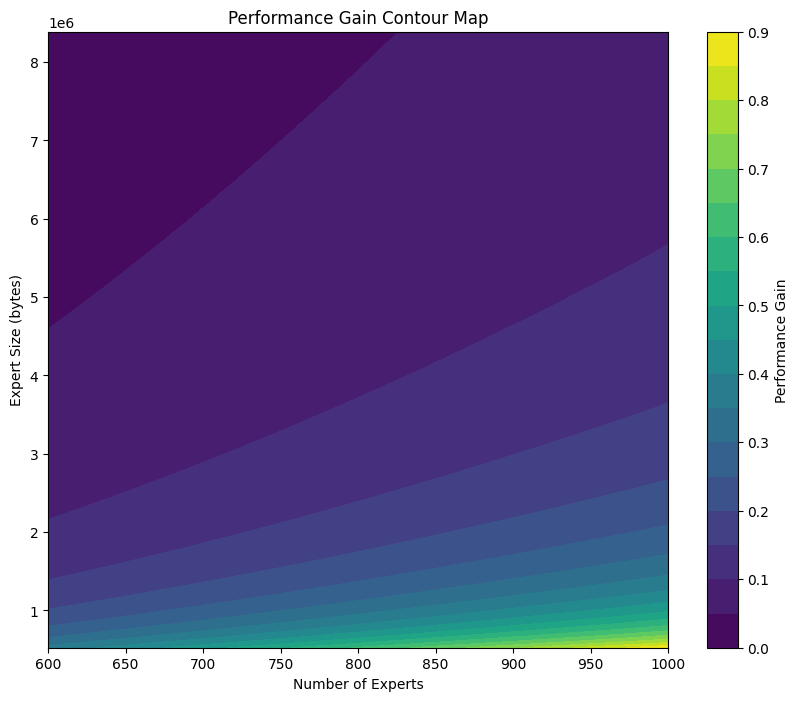

In [39]:
# Parameter ranges for number of experts:
# from 100 to 1500 experts in steps of 20.
num_experts_range = np.linspace(600, 1000, 20)

# Parameter range for the size of experts:
# start with 512KB and go up to 8MB.
# Use 512KB steps.
expert_sizes_range = np.linspace(1024 * 512, 1024 * 1024 * 8, 1024 * 512)

# Calculate performance matrix
perf_matrix = np.zeros((len(expert_sizes_range), len(num_experts_range)))
for i, size in enumerate(expert_sizes_range):
    for j, num_experts in enumerate(num_experts_range):
        config = MoEConfig(int(num_experts), int(size), 8)
        perf_matrix[i, j] = gh200_simulator.calculate_performance_gain(config)

# Plot contour graph
visualizer.plot_performance_contour(
    num_experts_range, expert_sizes_range, perf_matrix, "Performance Gain Contour Map"
)

Notice the more stable curbe as number of experts and size of experts increase on the unified memory system.

# Analysis

This demonstrates a few key principles proposed by Wes Medford, et al:

1. Cache efficiency improves with increased number of experts in a MoE model, following the predicted logorithmic relationship
2. Expert size has an inverse relationship with performance, as predicted by the β scaling factor. As the size of experts increase, performance gains are negated by cache misses.
3. Contour map analysis between a typical GPU system and the unified memory system reveals the steady curve of performance gains as proposed in the MoE scaling law: in a unified memory system with fast cache/memory on-board, performance gains are achievable over GPU based systems.

#### Custom Experiments

You can modify the parameters above to explore different scenarios:

- Adjust system configuration parameters to match different hardware
- Change expert counts and sizes to match your model architecture
- Modify experts_per_forward to reflect different routing strategies

See the `scaling.py` script for more details.